# $sin(x)$

This notebook shows how you can use a Gaussian Process to estimate a noisy $sin(x)$ with limited data.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

import theano
import numpy as np
import matplotlib.pyplot as plt

from gp import GaussianProcess

In [3]:
def secret_function(x, noise=0.0):
    return np.sin(x) + noise * np.random.normal(size=x.shape)

In [4]:
def as_shared(x, name, borrow=True):
    return theano.shared(value=x, name=name, borrow=borrow)

In [5]:
def print_mean_squared_error(gp, x, y):
    mu = gp.compute_mean(x)
    error = np.average((mu - y)**2)
    print("mean squared error", error)

In [6]:
def print_log_likelihood(gp, x, y):
    training_data = {gp.X: x, gp.Y: y}
    print("log likelihood", np.asscalar(gp.log_likelihood.eval(training_data)))

In [7]:
def print_hyperparameters(gp):
    for param in gp.hyperparameters:
        print(param.name, param.get_value())

In [8]:
def plot_variance(gp, x, y, title=None, std_factor=1.0):
    mu = gp.compute_mean(x)
    std = gp.compute_standard_deviation(x) * std_factor

    plt.figure(figsize=(12, 6))
    samples_plt, = plt.plot(
        gp.X_train.get_value(), gp.Y_train.get_value(),
        "bs", ms=4, label="Sampled points")
    y_plt, = plt.plot(x, y, "k--", label="Ground truth")
    mean_plt, = plt.plot(x, mu, "r", label="Estimate")
    std_plt = plt.gca().fill_between(
        x.flat, (mu - 3 * std).flat, (mu + 3 * std).flat,
        color="#dddddd", label="Three standard deviations")
    plt.axis([-4, 4, -2, 2])
    plt.title("Gaussian Process Estimate" if title is None else title)
    plt.legend(handles=[samples_plt, y_plt, mean_plt, std_plt])
    plt.show()

We sample 10 points at random 4 times and push them through our *secret* function. We reuse the same points simply to show that the $sin(x)$ function is indeed noisy and that the Gaussian Process is robust against it.

In [9]:
# Training data.
X = np.random.uniform(-4, 4, 10).reshape(-1, 1)
X = np.vstack([X, X, X, X])
X = as_shared(X, "X")
Y = as_shared(secret_function(X.get_value(), noise=1e-1), "Y")

In [10]:
# Test data.
x = as_shared(np.linspace(-4, 4, 1000).reshape(-1, 1), "x")
y = as_shared(secret_function(x.get_value(), noise=0.0), "y")

In [11]:
# Construct GP.
gp = GaussianProcess()
gp.fit(X, Y, skip_optimization=True)
gp.compile()

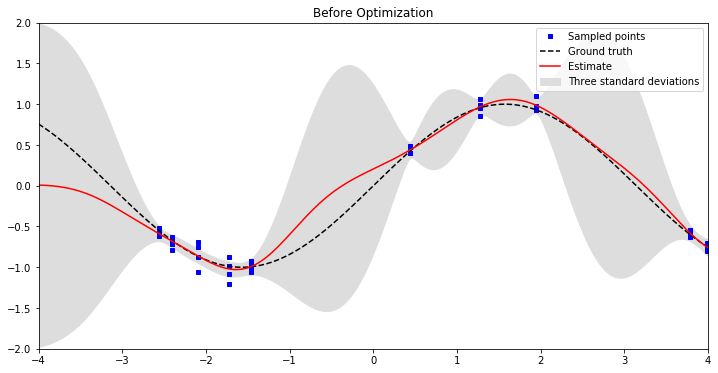

mean squared error 0.0451786973724
log likelihood -3.384726776912842
sigma_s 0.44429498008194623
sigma_s 0.6747321227398175
sigma_n 0.06705783512597645


In [12]:
plot_variance(gp, x.get_value(), y.get_value(), title="Before Optimization")
print_mean_squared_error(gp, x.get_value(), y.get_value())
print_log_likelihood(gp, X.get_value(), Y.get_value())
print_hyperparameters(gp)

In [13]:
gp.fit(X, Y)

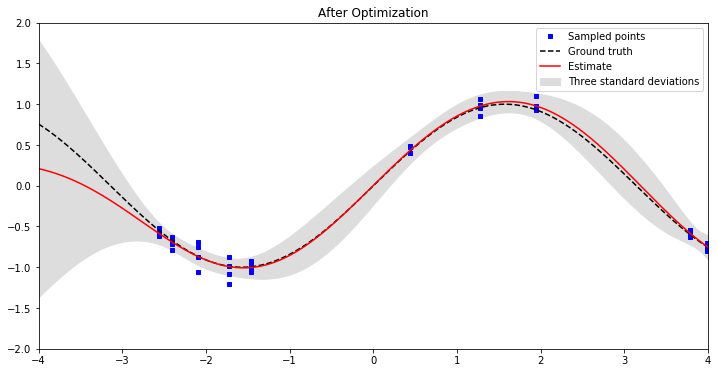

mean squared error 0.0167896152175
log likelihood 14.474495637086477
sigma_s 2.5260682040930345
sigma_s 1.0
sigma_n 0.11195980449225691


In [14]:
plot_variance(gp, x.get_value(), y.get_value(), title="After Optimization")
print_mean_squared_error(gp, x.get_value(), y.get_value())
print_log_likelihood(gp, X.get_value(), Y.get_value())
print_hyperparameters(gp)